In [22]:
import torch
import tiktoken
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from gpt_download import download_and_load_gpt2
from previous_chapter import GPTModel, load_weights_into_gpt, generate_text_simple, text_to_token_ids, token_ids_to_text

In [2]:
import io
import zipfile
import requests
import pandas as pd


def fetch_spam_dataframe() -> pd.DataFrame:
    url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
    backup_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"

    for u in [url, backup_url]:
        try:
            response = requests.get(u, timeout=60)
            response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
                with zf.open("SMSSpamCollection") as f:
                    return pd.read_csv(f, sep="\t", header=None, names=["Label", "Text"])
        except (requests.exceptions.RequestException, TimeoutError) as e:
            print(f"URL 실패: {e}. 다음 URL을 시도합니다...")

    raise RuntimeError("모든 URL에서 데이터 다운로드에 실패했습니다.")


df = fetch_spam_dataframe()
print(df.head())

  Label                                               Text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
def create_balanced_dataset(df: pd.DataFrame):

    # "스팸" 샘플 개수 세기
    num_spam = df[df["Label"] == "spam"].shape[0]

    # "스팸" 샘플 개수와 일치하도록 "햄" 샘플을 무작위로 샘플링
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # "햄"과 "스팸"을 합침
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [6]:
def random_split(df: pd.DataFrame, train_frac: float, validation_frac: float):
    # 데이터프레임 전체 섞기
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 분할 인덱스 계산
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # 데이터프레임 분할
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.head()

,Label,Text
0,0,Dude how do you like the buff wind.
1,0,Tessy..pls do me a favor. Pls convey my birthd...
2,1,Reminder: You have not downloaded the content ...
3,1,Got what it takes 2 take part in the WRC Rally...
4,1,"Shop till u Drop, IS IT YOU, either 10K, 5K, £..."


In [7]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [8]:
class SpamDataset(Dataset):
    def __init__(self,
                 data: pd.DataFrame,
                 tokenizer: tiktoken.Encoding,
                 max_length: int | None = None,
                 pad_token_id: int = 50256):
        self.data = data
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_test[:self.max_length] for encoded_test in self.encoded_texts
            ]

        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [9]:
train_dataset = SpamDataset(
    data=train_df,
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [10]:
val_dataset = SpamDataset(
    data=validation_df,
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    data=test_df,
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [11]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [12]:
print("훈련 세트 로더:")
for input_batch, target_batch in train_loader:
    break

print("입력 배치 차원:", input_batch.shape)
print("레이블 배치 차원", target_batch.shape)

훈련 세트 로더:
입력 배치 차원: torch.Size([8, 120])
레이블 배치 차원 torch.Size([8])


In [13]:
print(f"{len(train_loader)}개 훈련 배치")
print(f"{len(val_loader)}개 검증 배치")
print(f"{len(test_loader)}개 테스트 배치")

130개 훈련 배치
19개 검증 배치
38개 테스트 배치


In [14]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG: GPTConfig = {
    "vocab_size": 50257,     # 어휘사전 크기
    "context_length": 1024,  # 문맥 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # 쿼리-키-값 편향
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"데이터셋 길이 {train_dataset.max_length}가 모델의 문맥 "
    f"길이 {BASE_CONFIG['context_length']}를 초과합니다. `max_length={BASE_CONFIG['context_length']}`로 "
    f"데이터 셋을 다시 초기화하십시오."
)

In [19]:


model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 49.3kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:03<00:00, 333kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 174kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [27:25<00:00, 302kiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 8.98MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 435kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 321kiB/s]  


In [27]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you"""""""!"""""""


In [23]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [24]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [25]:
for param in model.parameters():
    param.requires_grad = False

In [26]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [28]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [29]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("입력:", inputs)
print("입력 차원:", inputs.shape) # shape: (배치 크기, 토큰 수)

입력: tensor([[5211,  345,  423,  640]])
입력 차원: torch.Size([1, 4])


In [30]:
with torch.no_grad():
    outputs = model(inputs)

print("출력:\n", outputs)
print("출력 차원:", outputs.shape)

출력:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
출력 차원: torch.Size([1, 4, 2])


In [31]:
print("마지막 출력 토큰:", outputs[:, -1, :])

마지막 출력 토큰: tensor([[-3.5983,  3.9902]])


In [32]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("클래스 레이블:", label.item())

클래스 레이블: 1


In [33]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("클래스 레이블:", label.item())

클래스 레이블: 1


In [34]:
def calc_accuracy_loader(
        data_loader: DataLoader,
        model: GPTModel,
        device: torch.device,
        num_batches: int | None = None
) -> float:
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()

        else:
            break

    return correct_predictions / num_examples



In [35]:
def determine_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        # 파이토치 2.9 이상에서는 mps 결과가 안정적입니다.
        major, minor = map(int, torch.__version__.split(".")[:2])
        if (major, minor) >= (2, 9):
            return torch.device("mps")
        else:
            return torch.device("cpu")
    else:
        return torch.device("cpu")

device = determine_device()
print(f"Using {device} device.")

Using mps device.


In [36]:
model.to(device) # nn.Module 클래스의 경우 model = model.to(device) 할당문이 필요하지 않습니다.

torch.manual_seed(123) # 데이터 로더에서 셔플링하기 때문에 재현성을 위해

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 46.25%
검증 정확도: 45.00%
테스트 정확도: 48.75%


In [37]:
def calc_loss_batch(input_batch: torch.Tensor, target_batch: torch.Tensor, model: GPTModel, device: torch.device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # 마지막 출력 토큰의 로짓
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [38]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # num_batches가 데이터 로더의 배치 수를 초과하는 경우
        # 데이터 로더의 총 배치 수와 일치하도록 배치 수를 줄입니다.
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [39]:
with torch.no_grad(): # 효율성을 위해 그레이디언트 추적을 비활성화합니다. 아직 훈련하지 않기 때문입니다.
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"훈련 손실: {train_loss:.3f}")
print(f"검증 손실: {val_loss:.3f}")
print(f"테스트 손실: {test_loss:.3f}")

훈련 손실: 2.453
검증 손실: 2.583
테스트 손실: 2.322


In [41]:
# 5장의 `train_model_simple`과 전체적으로 동일
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # 손실 및 처리한 샘플 수를 위한 리스트 초기화
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # 메인 학습 루프
    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 이전 배치 반복에서 얻은 손실의 그레이디언트 재설정
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 손실 그레이디언트 계산
            optimizer.step() # 손실 그레이디언트를 사용하여 모델 가중치 업데이트
            examples_seen += input_batch.shape[0] # 새로 추가: 토큰 대신 샘플 추적
            global_step += 1

            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"에포크 {epoch+1} (Step {global_step:06d}): "
                      f"훈련 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")

        # 각 에포크 후 정확도 계산
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"훈련 정확도: {train_accuracy*100:.2f}% | ", end="")
        print(f"검증 정확도: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

# 5장과 동일
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [42]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"훈련 소요 시간: {execution_time_minutes:.2f}분")

에포크 1 (Step 000000): 훈련 손실 2.153, 검증 손실 2.392
에포크 1 (Step 000050): 훈련 손실 0.617, 검증 손실 0.637
에포크 1 (Step 000100): 훈련 손실 0.523, 검증 손실 0.557
훈련 정확도: 70.00% | 검증 정확도: 72.50%
에포크 2 (Step 000150): 훈련 손실 0.561, 검증 손실 0.489
에포크 2 (Step 000200): 훈련 손실 0.419, 검증 손실 0.397
에포크 2 (Step 000250): 훈련 손실 0.409, 검증 손실 0.353
훈련 정확도: 82.50% | 검증 정확도: 85.00%
에포크 3 (Step 000300): 훈련 손실 0.333, 검증 손실 0.320
에포크 3 (Step 000350): 훈련 손실 0.340, 검증 손실 0.306
훈련 정확도: 90.00% | 검증 정확도: 90.00%
에포크 4 (Step 000400): 훈련 손실 0.136, 검증 손실 0.200
에포크 4 (Step 000450): 훈련 손실 0.153, 검증 손실 0.132
에포크 4 (Step 000500): 훈련 손실 0.222, 검증 손실 0.137
훈련 정확도: 100.00% | 검증 정확도: 97.50%
에포크 5 (Step 000550): 훈련 손실 0.207, 검증 손실 0.143
에포크 5 (Step 000600): 훈련 손실 0.083, 검증 손실 0.074
훈련 정확도: 100.00% | 검증 정확도: 97.50%
훈련 소요 시간: 1.07분


In [43]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 훈련 및 검증 손실을 에포크에 따라 그립니다.
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 처리한 샘플 수를 위해 두 번째 x축을 만듭니다.
    ax2 = ax1.twiny()  # 동일한 y축을 공유하는 두 번째 x축을 만듭니다.
    ax2.plot(examples_seen, train_values, alpha=0)  # 눈금 정렬을 위한 보이지 않는 그래프
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # 공간을 확보하기 위해 레이아웃을 조정합니다.
    plt.show()

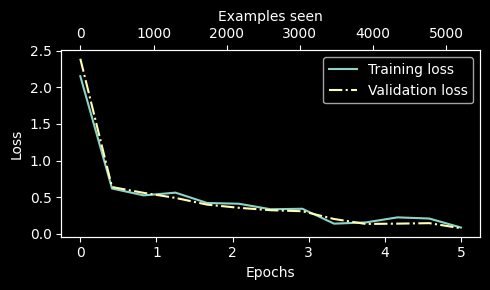

In [44]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

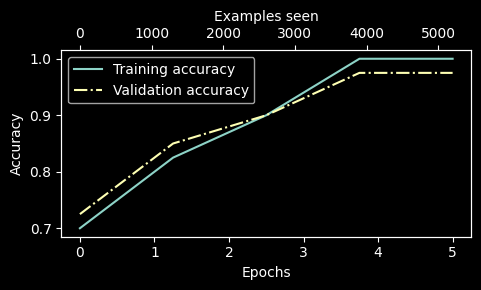

In [45]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [46]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 97.21%
검증 정확도: 97.32%
테스트 정확도: 95.67%


In [47]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # 모델에 대한 입력 준비
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    # 너무 긴 시퀀스 자르기
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length가 지정되지 않았습니다. 모델의 최대 문맥 길이를 사용하려면"
        "max_length=model.pos_emb.weight.shape[0]로 지정하세요."
    )
    assert max_length <= supported_context_length, (
        f"max_length({max_length})가 모델이 지원하는 문맥 길이({supported_context_length})를 초과했습니다."
    )
    # 또는 max_length=None인 경우를 안정적으로 처리하는 방법은 다음과 같습니다.
    # max_len = min(max_length, supported_context_length) if max_length else supported_context_length
    # input_ids = input_ids[:max_len]

    # 가장 긴 시퀀스로 패딩하기
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # 배치 차원 추가

    # 모델 추론
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # 마지막 출력 토큰의 로짓
    predicted_label = torch.argmax(logits, dim=-1).item()

    # 분류 결과 반환
    return "스팸" if predicted_label == 1 else "스팸아님"

In [48]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

스팸


In [49]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))


스팸아님
